In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from regimeaware.constants import DataConstants, SimulationParameters, Factors, HMMParameters, HISTORY_START_DT, HISTORY_END_DT
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["CMU Serif"]
})


fctr_rt = pd.read_pickle(f"{DataConstants.WDIR.value}/data/ff.pkl")
fctr_rt = fctr_rt.loc[HISTORY_START_DT:HISTORY_END_DT, Factors._member_names_]

In [2]:
N = 3  # Number of buckets, can be adjusted based on needs (e.g., BIC suggests 3 regimes)
buckets = {}
indices = fctr_rt.index
bucket_size = len(indices) // N
for n in range(1, N+1):
    start = (n-1) * bucket_size
    end = n * bucket_size if n < N else len(indices)
    buckets[n] = indices[start:end]

states_to_try = range(1, 11)

collect_bic = {}
for batch, idx in buckets.items():
    for n in states_to_try:
        mdl = GaussianHMM(
            n_components=n,
            covariance_type="diag",
            random_state=HMMParameters.SEED.value,
            min_covar=HMMParameters.MINCOV.value,
            tol=HMMParameters.TOL.value,
        )
        mdl.fit(fctr_rt.reindex(idx))
        collect_bic[(batch, n)] = mdl.bic(fctr_rt.reindex(idx))

bic = pd.Series(collect_bic)

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\franc\anaconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\franc\anaconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\franc\anaconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: User

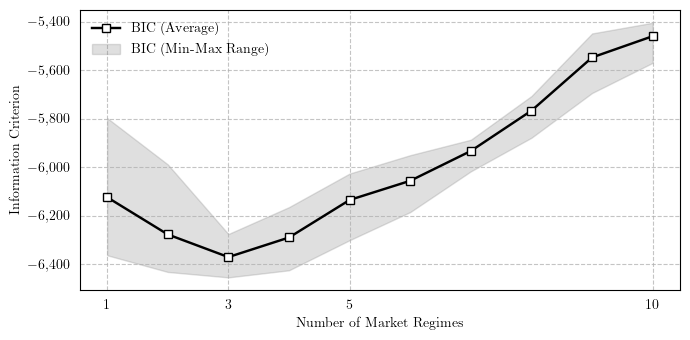

In [3]:
# Plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5), sharex=True, sharey=False)

ax.plot(bic.groupby(level=1).mean(), color='k', marker="s", mfc='white', lw="1.75", ls="-")
ax.grid(ls='--', alpha=.75)
ax.fill_between(
    bic.groupby(level=1).mean().index,
    # bic.groupby(level=1).mean() - bic.groupby(level=1).std(),
    # bic.groupby(level=1).mean() + bic.groupby(level=1).std(),
    bic.groupby(level=1).min(),
    bic.groupby(level=1).max(),
    color='gray',
    alpha=0.25
)

# ax.set_title('Information Criterion', weight='bold')
ax.set_ylabel('Information Criterion')
ax.set_xlabel('Number of Market Regimes')
ax.legend(['BIC (Average)', "BIC (Min-Max Range)"], frameon=False)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='both', bottom=False, left=False)
ax.set_xticks([1, 3, 5, 10])
plt.tight_layout()
plt.savefig(f"{DataConstants.WDIR.value}/img/state_calibration.pdf", dpi=300, transparent=True)
plt.show()
